In [1]:
import torch
from torch import nn
from torch.nn import functional as F

## Check GPU

In [3]:
def cpu():
    """Get the CPU device."""
    return torch.device('cpu')

def gpu(i=0):
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

def num_gpus():
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cpu'), device(type='cpu'), [])

## Convolution function

In [4]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    """ X -> 2D image
        K -> Kernel filter """

    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [5]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## Convolution Layer

In [6]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return F.conv2d(x, self.weight, bias=self.bias)

## Simple Edge detection

In [7]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [8]:
X.shape

torch.Size([6, 8])

In [9]:
K = torch.tensor([[1.0, -1.0]])

In [10]:
K.shape

torch.Size([1, 2])

In [11]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [12]:
X.shape

torch.Size([6, 8])

We can now apply the kernel to the transposed image. As expected, it vanishes.

In [13]:
X.t()

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [14]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## Learning a Kernel

In [15]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X1 = X.reshape((1, 1, 6, 8))
Y1 = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

In [16]:
for i in range(20):
    Y_hat = conv2d(X1)
    l = (Y_hat - Y1) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel (Gradient Descend update)
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 11.133
epoch 4, loss 3.659
epoch 6, loss 1.347
epoch 8, loss 0.527
epoch 10, loss 0.211
epoch 12, loss 0.086
epoch 14, loss 0.035
epoch 16, loss 0.014
epoch 18, loss 0.006
epoch 20, loss 0.002


In [17]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0049, -0.9948]])

In [18]:
# X.shape

In [19]:
# For Diagonal tensor construction
X2 = torchvision.transforms.functional.rotate(X1,45)
X2

tensor([[[[0., 0., 0., 0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 0., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0., 0., 0., 0.]]]])

## Exercises

1. Construct an image `X` with diagonal edges.
    1. What happens if you apply the kernel `K` in this section to it? [2 Marks]
    1. What happens if you transpose `X`? [1 Marks]
    1. What happens if you transpose `K`? [1 Marks]
1. Design some kernels manually.
    1. Given a directional vector $\mathbf{v} = (v_1, v_2)$, derive an edge-detection kernel that detects
       edges orthogonal to $\mathbf{v}$, i.e., edges in the direction $(v_2, -v_1)$. [1 Marks]
    1. Derive a finite difference operator for the second derivative. What is the minimum
       size of the convolutional kernel associated with it? Which structures in images respond most strongly to it? [1 Marks]
    1. How would you design a blur kernel? Why might you want to use such a kernel? [1 Marks]
    1. What is the minimum size of a kernel to obtain a derivative of order $d$? [1 Marks]
1. Create Covolution Layer to handle blur kernel. Apply it on designed input and output. [2 Marks]

## Ans **1.1**

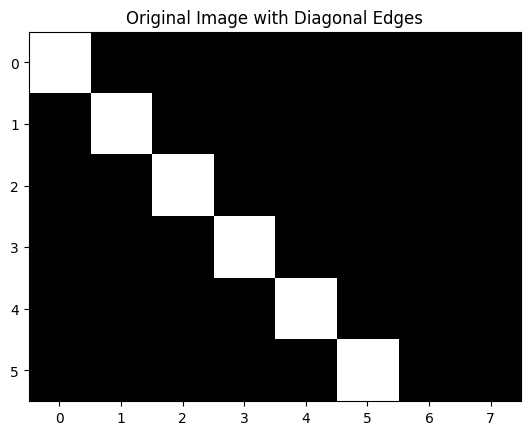

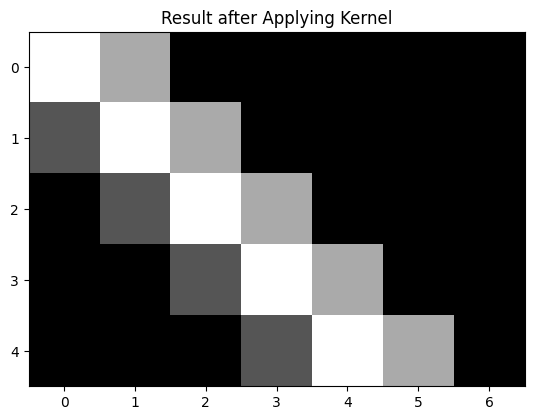

tensor([[3., 2., 0., 0., 0., 0., 0.],
        [1., 3., 2., 0., 0., 0., 0.],
        [0., 1., 3., 2., 0., 0., 0.],
        [0., 0., 1., 3., 2., 0., 0.],
        [0., 0., 0., 1., 3., 2., 0.]])

In [20]:
import matplotlib.pyplot as plt
import torchvision
K = torch.tensor([[0.0, 1.0],
                  [2.0, 3.0]])

X = torch.zeros((6, 8))

for i in range(min(X.shape[0], X.shape[1])):
    X[i, i] = 1


plt.imshow(X, cmap='gray')
plt.title('Original Image with Diagonal Edges')
plt.show()


def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

Y = corr2d(X, K)

plt.imshow(Y.detach().numpy(), cmap='gray')
plt.title('Result after Applying Kernel')
plt.show()

Y


## Ans **1.2**

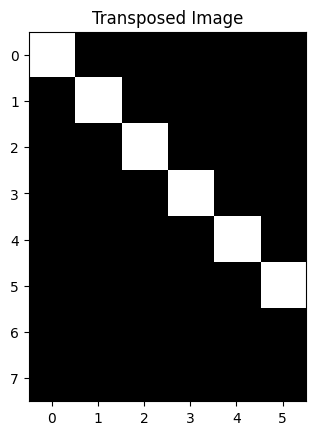

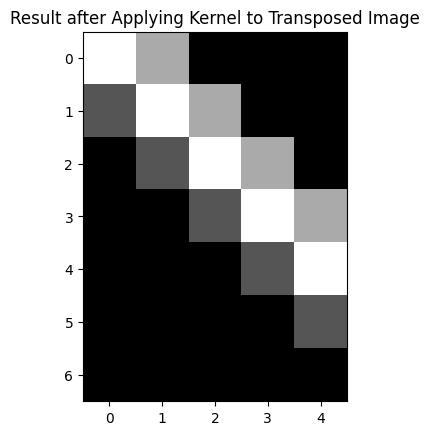

tensor([[3., 2., 0., 0., 0.],
        [1., 3., 2., 0., 0.],
        [0., 1., 3., 2., 0.],
        [0., 0., 1., 3., 2.],
        [0., 0., 0., 1., 3.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

In [21]:
X_transposed = X.t()

plt.imshow(X_transposed, cmap='gray')
plt.title('Transposed Image')
plt.show()

Y_transposed = corr2d(X_transposed, K)

plt.imshow(Y_transposed.detach().numpy(), cmap='gray')
plt.title('Result after Applying Kernel to Transposed Image')
plt.show()

Y_transposed


## Ans **1.3**

Original Kernel:
 tensor([[0., 1.],
        [2., 3.]])
Transposed Kernel:
 tensor([[0., 2.],
        [1., 3.]])


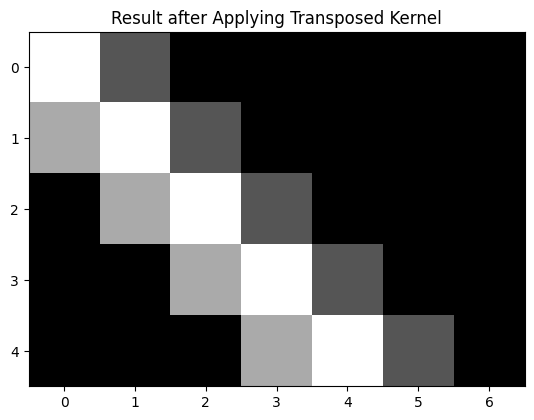

tensor([[3., 1., 0., 0., 0., 0., 0.],
        [2., 3., 1., 0., 0., 0., 0.],
        [0., 2., 3., 1., 0., 0., 0.],
        [0., 0., 2., 3., 1., 0., 0.],
        [0., 0., 0., 2., 3., 1., 0.]])

In [22]:
K_transposed = K.t()

print("Original Kernel:\n", K)
print("Transposed Kernel:\n", K_transposed)

Y_transposed_kernel = corr2d(X, K_transposed)

plt.imshow(Y_transposed_kernel.detach().numpy(), cmap='gray')
plt.title('Result after Applying Transposed Kernel')
plt.show()

Y_transposed_kernel


# **Ans 2**

In [33]:
#The edge-detection kernel for detecting edges orthogonal to the vector v=(v1,v2)
v=(1,2)
v1=v[0]
v2=v[1]
orth_edge_kernel = torch.tensor([[0, v1, 0],[-v2, 0, v2],[0, -v1, 0]])

In [ ]:
#  implemention of the second derivative operator as a convolution
second_derivative_operator_conv2d=torch.tensor([[0, 1, 0],[1, -4, 1],[0, 1, 0]])


The minimum size of the operator is 3*3 since that is the minimum for a laplacian operator
It can strongly detect:
1.   Edges
2.   Corners and Junctions

In [ ]:
#Designing a blur filter
blur_ker=torch.tensor([[1/9, 1/9, 1/9],
                      [1/9, 1/9, 1/9],
                      [1/9, 1/9, 1/9]])
gaussian_blur_ker=torch.tensor([[1, 2, 1],[2, 4, 2],[1, 2, 1]])

Blur filters maybe used for
1.   Noise Reduction
2.   Image smoothing




In [35]:
d1_filter=torch.tensor([[-1,1]])
d2_filter=torch.tensor([[0,1,0],[1,-4,1],[0,1,0]])
d3_filter=torch.tensor([[1,3,-3,1]])

## Ans **3**

In [30]:
import torch.nn.functional as F

class BlurConv2d(nn.Module):
    def __init__(self):
        super(BlurConv2d, self).__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        blur_ker = torch.tensor([[1/9, 1/9, 1/9],
                                    [1/9, 1/9, 1/9],
                                    [1/9, 1/9, 1/9]])


        self.conv.weight.data = blur_ker.unsqueeze(0).unsqueeze(0)

    def forward(self, x):
        return self.conv(x)

blur_conv_layer = BlurConv2d()

print("Blur Kernel:")
print(blur_conv_layer.conv.weight.data)


Blur Kernel:
tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


In [28]:
input_image = torch.tensor([[[[0, 0, 0, 0, 0, 0],
                              [0, 1, 1, 1, 1, 0],
                              [0, 1, 0, 0, 1, 0],
                              [0, 1, 0, 0, 1, 0],
                              [0, 1, 1, 1, 1, 0],
                              [0, 0, 0, 0, 0, 0]]]], dtype=torch.float32)

print("Input Image:")
print(input_image)


Input Image:
tensor([[[[0., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 1., 0.],
          [0., 1., 0., 0., 1., 0.],
          [0., 1., 0., 0., 1., 0.],
          [0., 1., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0., 0.]]]])


In [29]:
blurred_image = blur_conv_layer(input_image)

print("Blurred Image:")
print(blurred_image)


Blurred Image:
tensor([[[[0.1111, 0.2222, 0.3333, 0.3333, 0.2222, 0.1111],
          [0.2222, 0.3333, 0.4444, 0.4444, 0.3333, 0.2222],
          [0.3333, 0.4444, 0.5556, 0.5556, 0.4444, 0.3333],
          [0.3333, 0.4444, 0.5556, 0.5556, 0.4444, 0.3333],
          [0.2222, 0.3333, 0.4444, 0.4444, 0.3333, 0.2222],
          [0.1111, 0.2222, 0.3333, 0.3333, 0.2222, 0.1111]]]],
       grad_fn=<ConvolutionBackward0>)
